In this supplementary information, which can also be downloaded and run as a Jupyter notebook [here](https://github.com/atomec-project/mean_ionization_paper/blob/main/supp_info.ipynb) (link to be made public upon publication), we demonstrate how to use our average-atom code atoMEC to compute the MIS using the different methods described in the main paper. We also provide all the necessary inputs to reproduce the results in the paper.

There are (roughly-speaking) four parts in this supplementary material:

1. Convergence testing
2. Mean ionization state methods
3. Results: SCF calculations
4. Results: Mean ionization state calculations

First, we load the Python libraries and atoMEC modules which are required to run this notebook, as well as some general set-up:

In [1]:
# reload source code when it changes
%load_ext autoreload
%autoreload 2

# general imports
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import MIS_plots

# atoMEC imports
from atoMEC import Atom, models, config
from atoMEC.postprocess import localization, conductivity

# parallelize over the maximum number of cores
config.numcores = -1

# set the default printing output
default_stdout = sys.stdout
# base directory:
basedir = os.getcwd()

# Convergence testing

We start by detailing how to converge calculations in atoMEC, and the criteria we used in this paper. There are various parameters which should be checked for convergence. For all the boundary conditions, the main ones are:

* `nmax`: the maximum number of the principal quantum number $n$
* `lmax`: the maximum number of the angular quantum number $l$
* `grid_params`: dictionary parameter controlling the logarithmic grid, in particular the number of grid points `ngrid`

Furthermore, for the `bands` boundary condition, there is the additional dictionary parameter `band_params`. The important property within this is `nkpts` number of 'k' points, which is the number of states that are computed within all energy bands (spaced linearly in energy) in our model.

The convergence for the `nmax` and `lmax` paramaters can generally be chosen by eye, in other words by ensuring there are sufficient states such that the highest levels have (nearly) zero occoupations. Let us consider Aluminium at 10 eV and its ambient mass density, $2.7\ \textrm{g cm}^{-3}$.

In [2]:
# initialize an Aluminium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV")

# initiliaze a model with mostly default parameters - use quantum unbound electrons
Al_model = models.ISModel(Al_atom, unbound="quantum")

# guess nmax and lmax parameters
nmax = 5
lmax = 3
output = Al_model.CalcEnergy(nmax, lmax, write_info=True)


Welcome to atoMEC! 

Atomic information:
 
Atomic species                : Al 
Atomic charge / weight        : 13  / 26.982
Valence electrons             : 3  
Mass density                  : 2.7 g cm^-3
Voronoi sphere radius         : 2.997 Bohr / 1.586 Angstrom
Electronic temperature        : 0.3675 Ha /  10 eV / 1.16e+05 K
Wigner-Seitz radius           : 2.078 (Bohr)
Ionic coupling parameter      : 76.71
Electron degeneracy parameter : 0.8619


Using Ion-Sphere model
Ion-sphere model parameters: 
 
Spin-polarized                : False
Number of electrons           : 13
Exchange functional           : lda_x
Correlation functional        : lda_c_pw
Boundary condition            : dirichlet
Unbound electron treatment    : quantum
Shift KS potential            : True


Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -214.2613678      1.000e+00      9.999e-01     

In the above example, we see that `nmax=5` seems to be sufficiently large, but `lmax=3` is not, because the occupation of the $l=2,n=0$ state is 0.834, i.e. significantly above zero. We therefore choose a much larger value of `lmax` to check what is required for convergence. Let us try with $\textrm{lmax}=10$:

In [3]:
# re-run the calculation with larger lmax
lmax = 10
output = Al_model.CalcEnergy(nmax, lmax)

Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -214.2614028      1.000e+00      9.999e-01      1.000e+00
   1   -223.8611169      4.288e-02      1.026e+00      7.419e-01
   2   -237.0092435      5.548e-02      8.081e-01      1.792e-01
   3   -240.5714055      1.481e-02      9.512e-02      1.147e-01
   4   -241.9002982      5.494e-03      6.228e-02      7.125e-02
   5   -242.3646549      1.916e-03      3.950e-02      4.221e-02
   6   -242.5141104      6.163e-04      2.372e-02      2.372e-02
   7   -242.5584810      1.829e-04      1.337e-02      1.337e-02
   8   -242.5709206      5.128e-05      7.203e-03      7.761e-03
   9   -242.5743813      1.427e-05      3.772e-03      4.774e-03
  10   -242.5753302      3.912e-06      1.948e-03      3.055e-03
  11   -242.5756922      1.492e-06      1.014e-03      1.892e-03
  12   -242.5757635      2.938e-07      5.503e-04      

In the above, we clearly see that `lmax=10` is more than sufficient; in fact, it seems that `lmax=6` is enough in this case. Next, we shall test the convergence with respect to the number of grid points. We suppress the output from the SCF cycle since we shall run several calculations. If you are running this notebook, be patient as running all the calculations will take some time.

In [4]:
# set up the grid points to test over
ngrid_test = np.arange(500, 4500, 500)

# set up array to store the total energy, 1s core energy and chemical potential
output_arr = np.zeros((len(ngrid_test), 4))

# reset lmax to 6
lmax = 6

# change into the converence directory
os.chdir(basedir + "/convergence_tests/")
# loop over the ngrid array
for i, ngrid in enumerate(ngrid_test):
    # set the output to an external file
    sys.stdout = open("Al_ngrid_" + str(ngrid) + ".log", "w")
    output = Al_model.CalcEnergy(
        nmax, lmax, grid_params={"ngrid": ngrid}, write_info=False
    )
    output_arr[i, 0] = ngrid
    output_arr[i, 1] = output["energy"].F_tot
    output_arr[i, 2] = output["orbitals"].eigvals[0, 0, 0, 0]
    output_arr[i, 3] = config.mu

os.chdir(basedir)  # change back to base directory
sys.stdout = default_stdout  # change output back to console

We tabulate the total energy, core $1s$ energy level and chemical potential $\mu$ below to check their convergence with respect to the grid size.

In [5]:
# import package to make nice tables
import tabulate

# define table headings
headers = ["ngrid", "F tot", "e_1s", "mu"]

# create table
conv_tbl = tabulate.tabulate(
    output_arr,
    headers,
    tablefmt="presto",
    floatfmt=["4.0f", "7.3f", "7.3f", "7.3f"],
    stralign="right",
)
print(conv_tbl)

   ngrid |    F tot |    e_1s |      mu
---------+----------+---------+---------
     500 | -243.265 | -54.713 |   0.189
    1000 | -242.577 | -54.623 |   0.219
    1500 | -242.345 | -54.594 |   0.229
    2000 | -242.229 | -54.580 |   0.235
    2500 | -242.159 | -54.572 |   0.238
    3000 | -242.113 | -54.566 |   0.240
    3500 | -242.080 | -54.562 |   0.241
    4000 | -242.055 | -54.559 |   0.242


The degree of convergence required depends on various factors, such as the error that the user is willing to tolerate and the property that is being computed. In AA models, there are already a number of quite serious approximations which create uncertainty in the results, so typically we can use more relaxed convergence criteria than a full DFT-MD simulation. The property we are interested in for the purposes of this paper is the MIS, which is sensitive to the energy eigenvalues and chemical potential but not the total energy. Furthermore, we aim to benchmark our results agaist experiments which of course have some uncertainty for measurements of the free electron density.

With the above factors taken into account, we typically aim for convergence of around $0.01\ \textrm{Ha}$ in the core $1s$ energy level and the chemical potential $\mu$. Based on the above table, this indicates a reasonable choice is `ngrid=3000`. In theory, this number should be checked for each value of temperature and density calculated. In practise, it is reasonable to test it for a few select values in the temperature or density range spanned and interpolate to the other values.

As mentioned, when the `bands` boundary condition is used, we must also test convergence with respect to the number of orbitals `nkpts` per band. We perform a similar convergence check to before, only now we shall we probe the lowest energy eigenvalue in the conduction band, instead of the $1s$ core energy level. This is because, under these conditions, the $1s$ level is fully isolated from the neighbouring spheres and so is not part of an energy band.

In [6]:
# set up the nkpts array
nkpts_arr = np.arange(10, 110, 10)

# change the boundary condition
Al_model.bc = "bands"

# reset the output array
output_arr = np.zeros((len(nkpts_arr), 4))

# change to convergence directory
os.chdir(basedir + "/convergence_tests/")
# loop over the nkpts array with a coarse ngrid value (independent)
for i, nkpts in enumerate(nkpts_arr):
    # set the output to an external file
    sys.stdout = open("Al_nkpts_" + str(ngrid) + ".log", "w")
    output = Al_model.CalcEnergy(
        nmax,
        lmax,
        grid_params={"ngrid": 1000},
        write_info=False,
        band_params={"nkpts": nkpts},
    )
    output_arr[i, 0] = nkpts
    output_arr[i, 1] = output["energy"].F_tot
    output_arr[i, 2] = output["orbitals"].eigvals[0, 0, 0, 2]
    output_arr[i, 3] = config.mu

os.chdir(basedir)  # change back to base directory
sys.stdout = default_stdout  # change output back to console

In [7]:
# create table
headers = ["nkpts", "F tot", "e_c", "mu"]
conv_tbl = tabulate.tabulate(
    output_arr,
    headers,
    tablefmt="presto",
    floatfmt=["4.0f", "7.3f", "7.3f", "7.3f"],
    stralign="right",
)
print(conv_tbl)

   nkpts |    F tot |     e_c |      mu
---------+----------+---------+---------
      10 | -243.814 |  -0.131 |  -0.038
      20 | -243.859 |  -0.130 |  -0.053
      30 | -243.869 |  -0.130 |  -0.057
      40 | -243.873 |  -0.130 |  -0.058
      50 | -243.876 |  -0.130 |  -0.059
      60 | -243.877 |  -0.130 |  -0.059
      70 | -243.878 |  -0.130 |  -0.059
      80 | -243.878 |  -0.130 |  -0.060
      90 | -243.879 |  -0.130 |  -0.060
     100 | -243.879 |  -0.130 |  -0.060


We see from the above that, for this example, the quantities of interest are very well converged already with `nkpts=20`. However, the time taken is almost identical regardless of the number of $k$-points used. This is because the computationally dominant step is actually the diagonalization of the Hamiltonian, which is required to find the limits of the band energies. Therefore we are free to choose a relatively large value of `nkpts` without much affect on the computational demands. Typically the default value of `nkpts=50` in atoMEC is a reasonable choice. 

# Mean ionization state comparisons

 In this section, we explain how to compute the MIS in atoMEC via the various methods described in the paper. Afterwards, we provide the input (and output) for the calculations that were done in the paper, so that the reader can reproduce these results.

## Calculation of MIS using the threshold method

As seen in Eq. (1) of the main paper, the MIS can be computed as the integral over all the positive energy states:

\begin{equation}
\bar{Z} = \int_{v(R_\textrm{VS})}^\infty g(\epsilon) f_\textrm{FD}(\epsilon)\,,
\end{equation}

where $g(\epsilon)$ is the density-of-states (DOS), $f_\textrm{FD}(\epsilon)$ the Fermi--Dirac distribution, and $v(R_\textrm{VS})$ the value of the potential at the sphere's edge (the Voronoi sphere (VS) radius).

In atoMEC, when `unbound="quantum"`, all the orbitals are treated identically. The integral in the above equation therefore becomes a sum over all the states with energies above $v(R_\textrm{VS})$,

\begin{equation}
\bar{Z} = 2\sum_{k,l,n} (2l+1) w_{k} f_{k ln} \Theta(\epsilon_{k ln}-v(R_\textrm{VS}))\,,
\end{equation}

where $\Theta$ is the Heaviside step function.

As was seen in the earlier examples, the MIS calculate via the threshold method is printed by default at the end of every SCF run anyway. It is also a property of the `staticKS.Density` object so can be accessed through that if desired. Let us again run a calculation for Aluminium at ambient conditions:

In [8]:
# first set up and run a calculation
# set up the ISModel
Al_model = models.ISModel(
    Al_atom,
    bc="dirichlet",
    unbound="quantum",
    xfunc_id="lda_x",
    cfunc_id="lda_c_pw",
    write_info=False,
)

# reset temperature and density
Al_atom.temp = 0.01
Al_atom.density = 2.7

# set the values of nmax and lmax
nmax = 5
lmax = 3

# run the SCF calculation
output = Al_model.CalcEnergy(
    nmax,
    lmax,
    scf_params={"mixfrac": 0.6, "maxscf": 50},
    grid_params={"ngrid": 2000},
    write_info=True,
)

Normal temperature range for atoMEC is 0.01 -- 100 eV 

Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -209.8109071      1.000e+00      9.999e-01      1.000e+00
   1   -221.4389732      5.251e-02      1.037e+00      7.441e-01
   2   -234.9067423      5.733e-02      7.929e-01      4.094e-01
   3   -240.1006271      2.163e-02      2.054e-01      6.883e-02
   4   -240.2207300      5.000e-04      3.698e-02      1.623e-02
   5   -240.2224408      7.122e-06      3.266e-03      6.350e-03
   6   -240.2226336      8.028e-07      1.237e-03      2.632e-03
   7   -240.2226289      1.983e-08      4.429e-04      1.020e-03
   8   -240.2226596      1.279e-07      1.583e-04      5.192e-04
   9   -240.2226940      1.431e-07      5.759e-05      2.568e-04
  10   -240.2226599      1.417e-07      2.034e-05      3.422e-04
  11   -240.2226618      7.880e-09      1.004e-05      3.522e-04

In [9]:
# extract the MIS
MIS = output["density"].MIS

# print the 1st array element (only element in a spin unpolarized calculation)
print("MIS = ", round(MIS[0], 2))

MIS =  3.0


In this case, the MIS computed with the threshold approach is equal to $3.0$, which is the number of orbitals in the conduction band for Aluminium at ambient conditions.

## Calculation of MIS using the counting method

As seen in Eq. (15) of the main paper, the MIS alternatively be computed by subtracting the occupations of the core states (determined by the user) from the total electron number, i.e.

\begin{equation}
\bar{Z} = N_\textrm{e} - 2\sum_{k} w_{k} \sum_{l,n\in \textrm{b}} (2l+1) f_{kln} 
\end{equation}

In atoMEC, this method is accessed via the `postprocessing.localization` module. The core states should be specified by their $l,n$ co-ordinates, where $l$ and $n$ are the quantum numbers. For our Aluminium example, we know the core states are the $1s$, $2s$ and $2p$ states: respectively, these are given by $(0,0)$, $(1,0)$ and $(0,1)$ (in atoMEC, the $n$-index always starts at zero relative to the paired $l$ index). Therefore we have:

In [10]:
# extract the orbitals from the output of the SCF calculation
Al_orbs = output["orbitals"]

# choose the core orbitals - 1s, 2s and 2p
core_indices = [(0, 0), (1, 0), (0, 1)]

# compute the MIS with the counting method
MIS_count = localization.MIS_count(Al_model, Al_orbs, core_indices)
print("MIS = ", round(MIS[0], 2))

MIS =  3.0


In this case, the MIS again yields the expected value of 3.

## Calculation of MIS using the electron localization function

As seen in Eq. (22) of the main paper, the electron localization function for a spherically symmetric system, assuming the approximate form of the second-order gradient expansion for the density, is given by:

\begin{equation}
D(r) = D_0(r) - \frac{1}{9} \frac{1}{n(r)} \left| \frac{\textrm{d}n(r)}{\textrm{d}r}\right|^2 + \frac{1}{6} \left(  \frac{2}{r} \frac{\textrm{d}n(r)}{\textrm{d}r} +  \frac{\textrm{d}^2 n(r)}{\textrm{d}r^2}\right)\,.
\end{equation}



In atoMEC the ELF is accessed through the `postprocess.localization` module. In the following, we calculate and plot the ELF for our Aluminium example. 

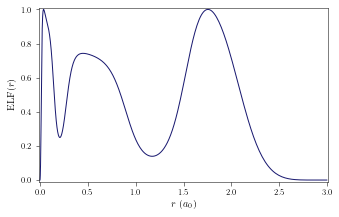

In [11]:
# import localization module
from atoMEC.postprocess import localization

# Set up the ELF object
# use the "density" version of the ELF (uses second order gradient expansion for KED)
ELF_Al = localization.ELFTools(
    Al_atom, Al_model, output["orbitals"], output["density"], method="density"
)
xgrid = ELF_Al._xgrid
rgrid = np.exp(xgrid)

# extract the ELF function
ELF_func = ELF_Al.ELF

# General figure set-up
figdims = MIS_plots.fig_initialize(latex=True, setsize=True, fraction=0.8)
fig, ax = plt.subplots(1, 1, figsize=(figdims))

# plot the ELF function
ax.plot(rgrid, ELF_func[0], color="midnightblue")

ax.set_xlim(-0.01, 3.01)
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r"$r\ (a_0)$")
ax.set_ylabel(r"ELF$(r)$")
plt.savefig("/home/callow46/mean_ionization_paper/figures/ELF_example.pdf")

Note that, if instead one wanted to use the orbital-dependent form of the ELF intstead of the second-order gradient expansion, one should specify `method="orbitals"` in the call to the `ELFTools` object.

The next stage is to use the ELF to compute the number of electrons in a given shell. This is done by finding the positions of the minima of the ELF, and integrating the density between them, as explained in the main paper. In atoMEC, we can access this data from the `N_shell` property of the `ELFTools` object:

In [12]:
# extract the number of electrons per shell
N_s = ELF_Al.N_shell[0]

for i in range(len(N_s)):
    print("The number of electrons in the n =", i + 1, "shell =", round(N_s[i], 2))

The number of electrons in the n = 1 shell = 2.14
The number of electrons in the n = 2 shell = 7.75
The number of electrons in the n = 3 shell = 3.11


These numbers approximately match up to what we expect from ambient Aluminium: 2 electrons in the $n=1$ shell, 8 in the $n=2$ shell, and the remaining 3 electrons in the conduction band (which we call the $n=3$ shell here). As discussed in the main paper, extracting the MIS from this output requires some user input based on physical intuition, to decide which shells should be counted as bound and which free.

## Calculation of the MIS using the Kubo--Greenwood formula

As seen in eqs. (27) and (28) of the main manuscript, the KG conductivity formula in our AA model is given by

\begin{equation}
Z_{S_1,S_2} = 4 \sum_{nl\in S_1} \sum_{n'l'\in S_2} \sum_{m\in \{S_1,S_2\}} \frac{f_{nl} - f_{n'l'}}{\epsilon_{n'l'}-\epsilon_{nl}}|\nabla_{nn'll'm}^z|^2 \delta(l\pm 1 - l') \Theta (\epsilon_{n'l'}-\epsilon_{nl}),
\end{equation}
with
\begin{equation}
\nabla_{nn'll'm}^z = \langle \phi_{n'l'm'} | \nabla_z| \phi_{nlm} \rangle
\end{equation}

In atoMEC the Kubo--Greenwood functionality is accessed through the `kubo_greenwood` module. We show how to extract the total number of electrons (to check the sum rule is satisfied) and the number of free electrons (i.e. the MIS) below.

The orbital subsets are chosen by specifying which orbitals are ''valence'' (this also includes core orbitals, i.e. everything that does not belong to the conduction band). We see how this done below. 

In [13]:
# first we re-run the Al calculation with more unoccupied orbitals
# this is required because the KG method needs empty orbitals to converge

# set the values of nmax and lmax
nmax = 25
lmax = 10

# run the SCF calculation
output = Al_model.CalcEnergy(
    nmax,
    lmax,
    scf_params={"mixfrac": 0.6, "maxscf": 50},
    grid_params={"ngrid": 2000},
    write_info=False,
)

func:'CalcEnergy' took: 54.5809 sec


In [14]:
# we need to define the 'valence' orbitals, which actually means everything not in the conduction band
# for solid Al at room temperature the valence orbitals are 1s, 2s and 2p
from atoMEC.postprocess import conductivity

valence_orbs = [(0, 0), (1, 0), (0, 1)]

# set up the Kubo-Greenwood object
kg = conductivity.KuboGreenwood(
    Al_atom, Al_model, output["orbitals"], valence_orbs=valence_orbs
)

# compute the total number of electrons
N_tot = kg.N_tot

# compute the number of free electrons
N_free = kg.N_free

# print the output
print("Total number of electrons = ", round(N_tot, 2))
print("Number of free electrons = ", round(N_free, 2))

Total number of electrons =  12.95
Number of free electrons =  3.29


In the above example, it can be seen that the total number of electrons equals 12.95, which is very close to the expected value of 13 for Alunimium (less than 1\% difference). Therefore it seems the values of `nmax` and `lmax` are large enough for the KG calculation to be converged. The number of free electrons is 3.29, which is close to the value of 3 that might be expected from physical intuition.

# Results: SCF calculations

In this section, we run the SCF calculations to get the KS orbitals and density. These are used as inputs for computing the MIS via the different methods, which we run through in the following sub-section. Note that the primary objective of atoMEC is not computationally efficiency, and thus the each SCF calculation may take up to ~20 minutes for the inputs used in the paper. If you wish to run all the SCF calculations, we provide all necessary inputs but we suggest to run the calculations on a separate cluster.


## SCF calculations: Carbon

In you wish to run the SCF calculations, please set `run_SCF_calcs = True` below:

In [15]:
# whether to run the SCF calculations
run_SCF_calcs = False

First, we set up the calculations for Carbon at $T=100$ eV, under a range of densities.

In [16]:
import pickle as pkl

# ensure parallelism is on
config.numcores = 9
# set up the base Carbon atom
C_atom = Atom("C", 100, density=1.0, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(C_atom, unbound="quantum", write_info=False)
# define the boundary conditions
bcs = ["dirichlet", "neumann", "bands"]
# define the densities
densities = np.array([1, 2, 5, 10, 20, 50, 80, 100, 150, 200, 300, 400], dtype=float)
# set the lmax parameter (same for all bcs)
lmax = 20
# grid parameters
grid_params = {"ngrid": 3000}
# band_parameters
band_params = {"nkpts": 50}
# base directory
basedir = "/home/callow46/mean_ionization_paper"

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Carbon/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
        else:
            nmax = 20
        # loop over the densities
        for density in densities:
            # set the output to an external file
            sys.stdout = open("C_" + str(density) + ".log", "w")
            # set the density
            C_atom.density = density
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params=band_params,
                dos_file="dos_" + str(density) + ".csv",
            )
            # save the orbitals and density output
            orbfile = "C_orbs_" + str(density) + ".pkl"
            densfile = "C_dens_" + str(density) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f)

# reset output to terminal
sys.stdout = default_stdout

Normal temperature range for atoMEC is 0.01 -- 100 eV 



## SCF calculations: Beryllium

Next, we set up the calculations for Beryllium with fixed density $\rho_\textrm{m} = 1.85\ \textrm{g cm}^{-3}$, for a range of temperatures.

In [17]:
# set up the base Beryllium atom
Be_atom = Atom("Be", 1, density=1.85, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Be_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(2, 86, 4, dtype=float)
# set the lmax parameter (same for all bcs)
lmax = 15
# grid parameters
grid_params = {"ngrid": 3000}

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Beryllium/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
        else:
            nmax = 15
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Be_" + str(temp) + ".log", "w")
            # set the density
            Be_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Be_orbs_" + str(temp) + ".pkl"
            densfile = "Be_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)

# reset output to terminal
sys.stdout = default_stdout

## SCF calculations: Aluminium (i)

We first run the necessary SCF calculations for the first Aluminium experiment, for which the density is fixed at $2.7 \textrm{g cm}^{-3}$ and the temperature is varied between 10 and 30 eV.

In [18]:
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(10, 36, 1, dtype=float)
# grid parameters
grid_params = {"ngrid": 3000}

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Aluminium/expt_comp_1/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
            lmax = 20
        else:
            nmax = 10
            lmax = 15
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Al_" + str(temp) + ".log", "w")
            # set the density
            Al_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Al_orbs_" + str(temp) + ".pkl"
            densfile = "Al_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)


# reset output to terminal
sys.stdout = default_stdout

## SCF calculations: Aluminium (ii)

We first run the necessary SCF calculations for the first Aluminium experiment, for which the density is fixed at $2.7\ \textrm{g cm}^{-3}$ and the temperature is varied between 0 and 100 eV. Because we span a wider range of temperatures in this run compared to the last, we need to use larger values of `nmax` and `lmax` to include more orbitals.

In [19]:
# no need to re-define the atom or model this time
# define the temperatures
temps = np.arange(0, 105, 5, dtype=float)
temps[0] = 0.01  # redefine so we don't have zero temperature
# grid parameters
grid_params = {"ngrid": 3000}
# universal lmax
lmax = 20

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Aluminium/expt_comp_2/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 40
        else:
            nmax = 20
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Al_" + str(temp) + ".log", "w")
            # set the density
            Al_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Al_orbs_" + str(temp) + ".pkl"
            densfile = "Al_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)

# reset output to terminal
sys.stdout = default_stdout

# Results: Mean ionization state calculations

We now proceed to compute the MIS via the three methods discussed. 

## Mean ionization state calculations: Carbon

As mentioned, both the ELF and KG methods need some user-defined input to determine which orbitals should be treated as bound vs free (for the ELF method), or conduction or valence vs conduction (for the KG method). For Carbon under the conditions we probe, we take the $1s$ orbital (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in this band (i.e. the $n=1$ principle quantum level) is bound and that the remaining electron density is free.

In [20]:
# set up the base Carbon atom
C_atom = Atom("C", 100, density=1.0, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(C_atom, unbound="quantum", write_info=False)
# define the boundary conditions
bcs = ["dirichlet", "neumann", "bands"]
# define the densities
densities = np.array([1, 2, 5, 10, 20, 50, 80, 100, 150, 200, 300, 400], dtype=float)
# base directory
basedir = "/home/callow46/mean_ionization_paper"

# set up empty MIS arrays
MIS_thresh = np.zeros((len(densities), 4))
MIS_ELF = np.zeros((len(densities), 4))
MIS_kg = np.zeros((len(densities), 3))
MIS_count = np.zeros((len(densities), 4))
MIS_thresh[:, 0] = densities
MIS_ELF[:, 0] = densities
MIS_kg[:, 0] = densities
MIS_count[:, 0] = densities

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Carbon/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the densities
    for j, density in enumerate(densities):
        # save the orbitals and density output
        orbfile = "C_orbs_" + str(density) + ".pkl"
        densfile = "C_dens_" + str(density) + ".pkl"
        logfile = "C_" + str(density) + ".log"
        C_atom.density = density
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        # set up input params
        (
            config.band_params["nkpts"],
            config.spindims,
            config.lmax,
            config.nmax,
        ) = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(C_atom, model, orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - N_ub_shell[0]
        MIS_count[j, i] = localization.MIS_count(model, orbs, [(0, 0)])
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = conductivity.KuboGreenwood(C_atom, model, orbs, valence_orbs=[(0, 0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free

# save the results
os.chdir(basedir + "/results/Carbon/")
header = "Density (g/cm^3), Z (dirichlet), Z (Neumann), Z (bands)"
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_count.csv", MIS_count, fmt="%8.4f", header=header, delimiter=",")
header = "Density (g/cm^3), N total, Z (dirichlet)"
np.savetxt("MIS_kg.csv", MIS_kg, fmt="%8.4f", header=header, delimiter=",")

Normal temperature range for atoMEC is 0.01 -- 100 eV 



/home/callow46/atoMEC/atoMEC/postprocess/localization.py:230: RuntimeWarning: divide by zero encountered in true_divide
  epdc = D_0 - (grad_dens) ** 2.0 / (9.0 * density) + lap_dens / 6.0


The results of the MIS calculations can be examined using the `csv` files saved in the above code.

## Mean ionization state calculations: Beryllium

For Beryllium under the conditions we probe, we take the $1s$ orbital (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in this band (i.e. the $n=1$ principle quantum level) is bound and that the remaining electron density is free.

In [21]:
# set up the base Beryllium atom
Be_atom = Atom("Be", 1, density=1.85, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Be_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(2, 86, 4, dtype=float)

# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps), 4))
MIS_ELF = np.zeros((len(temps), 4))
MIS_kg = np.zeros((len(temps), 3))
MIS_count = np.zeros((len(temps), 4))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps
MIS_count[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Beryllium/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        Be_atom.temp = temp
        # load the orbitals and density output
        orbfile = "Be_orbs_" + str(temp) + ".pkl"
        densfile = "Be_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        logfile = "Be_" + str(temp) + ".log"
        # set up input params
        (
            config.band_params["nkpts"],
            config.spindims,
            config.lmax,
            config.nmax,
        ) = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(Be_atom, model, orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - N_ub_shell[0]
        MIS_count[j, i] = localization.MIS_count(model, orbs, [(0, 0)])
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = conductivity.KuboGreenwood(Be_atom, model, orbs, valence_orbs=[(0, 0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free

# save the results
os.chdir(basedir + "/results/Beryllium/")
header = "Temperature (eV), Z (dirichlet), Z (Neumann), Z (bands)"
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_count.csv", MIS_count, fmt="%8.4f", header=header, delimiter=",")
header = "Temperature (eV) , N total, Z (dirichlet)"
np.savetxt("MIS_kg.csv", MIS_kg, fmt="%8.4f", header=header, delimiter=",")

The results of the MIS calculations can be examined using the `csv` files saved in the above code. 

To convert from the MIS to the free electron density, one can use the expression $n_\textrm{f} = (Z / N_\textrm{e}) * n_\textrm{e}$, where $n_\textrm{e}$ is the total electron density, and $N_\textrm{e}$ the total electron number. The total electron density (in cm$^{-3}$) is given by

In [22]:
# compute the volume in cm^3
from atoMEC import unitconv

radius_cm = Be_atom.radius * 1e-8 / unitconv.angstrom_to_bohr
Be_vol = (4 / 3) * np.pi * radius_cm**3
n_e = Be_atom.nele / Be_vol
print("Total electron density per cm^3 = {n_e:7.3e}".format(n_e=n_e))

Total electron density per cm^3 = 4.909e+23


## Mean ionization state calculations: Aluminium (i)

For Aluminium under the conditions we probe, we take the $1s,\ 2s,\ \textrm{and}\ 2p$ orbitals (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in the $n=1$ and $n=2$ principle quantum levels is bound and that the remaining electron density is free.

In [23]:
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(10, 36, 1, dtype=float)
# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps), 4))
MIS_ELF = np.zeros((len(temps), 4))
MIS_kg = np.zeros((len(temps), 3))
MIS_count = np.zeros((len(temps), 4))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps
MIS_count[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Aluminium/expt_comp_1/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        # load the orbitals and density output
        orbfile = "Al_orbs_" + str(temp) + ".pkl"
        densfile = "Al_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        logfile = "Al_" + str(temp) + ".log"
        # set up input params
        (
            config.band_params["nkpts"],
            config.spindims,
            config.lmax,
            config.nmax,
        ) = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(Al_atom, model, orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - (N_ub_shell[0] + N_ub_shell[1])
        MIS_count[j, i] = localization.MIS_count(model, orbs, [(0, 0), (0, 1), (1, 0)])
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = conductivity.KuboGreenwood(
                Al_atom, model, orbs, valence_orbs=[(0, 0), (0, 1), (1, 0)]
            )
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free

# save the results
os.chdir(basedir + "/results/Aluminium/expt_comp_1")
header = "Temperature (eV), Z (dirichlet), Z (Neumann), Z (bands)"
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_count.csv", MIS_count, fmt="%8.4f", header=header, delimiter=",")
header = "Temperature (eV), N total, Z (dirichlet)"
np.savetxt("MIS_kg.csv", MIS_kg, fmt="%8.4f", header=header, delimiter=",")

The results of the MIS calculations can be examined using the `csv` files saved in the above code. To convert from the MIS to the free electron density, the following code can be used.

In [24]:
# compute the volume in cm^3
radius_cm = Al_atom.radius * 1e-8 / unitconv.angstrom_to_bohr
Al_vol = (4 / 3) * np.pi * radius_cm**3
n_e = Al_atom.nele / Al_vol
print("Total electron density per cm^3 = {n_e:7.3e}".format(n_e=n_e))

Total electron density per cm^3 = 7.778e+23


## Mean ionization state calculations: Aluminium (ii)

For Aluminium under the conditions we probe, we take the $1s,\ 2s,\ \textrm{and}\ 2p$ orbitals (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in the $n=1$ and $n=2$ principle quantum levels is bound and that the remaining electron density is free.

In this case, as described in the main text, we do not just compute the MIS but also the excitation energy $E_K$. We define this excitation energy as the difference between the $1s$ energy level and the value of the potential at the sphere boundary $v_\textrm{s}(R_\textrm{VS})$; we then shift this energy by a constant, where the value of the constant is the difference between the excitation energy and the experimentally measured ionization energy at zero temperature $\Delta E^0_K$. In atoMEC, the orbital energies are by default defined relative to  $v_\textrm{s}(R_\textrm{VS})$, so the excitation energy is defined as $E_K = - \epsilon_{1s} + \Delta E^0_K$.

The experimental value of $E_K^0$ (i.e. the $K$-th ionization energy at zero temperature) is equal to 1559.6 eV \cite{thompson2001x}. The value of $E_K^0$ can be extracted from the $T = 0.01\ \textrm{eV}$ data point (effectively zero temperature) for each of the boundary conditions from the SCF calculations performed already.

In [25]:
# get conversion from hartree to eV
from atoMEC import unitconv

ha_to_eV = 1.0 / unitconv.ev_to_ha
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(0, 105, 5, dtype=float)
temps[0] = 0.01  # redefine so we don't have zero temperature
# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps), 4))
MIS_ELF = np.zeros((len(temps), 4))
MIS_kg = np.zeros((len(temps), 3))
MIS_count = np.zeros((len(temps), 4))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps
MIS_count[:, 0] = temps
# set up empty E_k array
E_K = np.zeros((len(temps), 4))
E_K[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Aluminium/expt_comp_2/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        # load the orbitals and density output
        orbfile = "Al_orbs_" + str(temp) + ".pkl"
        densfile = "Al_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        logfile = "Al_" + str(temp) + ".log"
        # set up input params
        (
            config.band_params["nkpts"],
            config.spindims,
            config.lmax,
            config.nmax,
        ) = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(Al_atom, model, orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - (N_ub_shell[0] + N_ub_shell[1])
        MIS_count[j, i] = localization.MIS_count(model, orbs, [(0, 0), (0, 1), (1, 0)])
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = conductivity.KuboGreenwood(
                Al_atom, model, orbs, valence_orbs=[(0, 0), (0, 1), (1, 0)]
            )
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free

        # compute the excitation energies
        if temp == 0.01:
            # define the energy shift
            E_shift = ha_to_eV * orbs.eigvals[0, 0, 0, 0] + 1559.6
        E_K[j, i] = -ha_to_eV * orbs.eigvals[0, 0, 0, 0] + E_shift

# save the results
os.chdir(basedir + "/results/Aluminium/expt_comp_2")
header = "Temperature (eV), Z (Dirichlet), Z (Neumann), Z (bands)"
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt="%8.4f", header=header, delimiter=",")
np.savetxt("MIS_count.csv", MIS_count, fmt="%8.4f", header=header, delimiter=",")
header = "Temperature (eV), N total, Z (dirichlet)"
np.savetxt("MIS_kg.csv", MIS_kg, fmt="%8.4f", header=header, delimiter=",")
header = "Temperature (eV), E_K (Dirichlet), E_K (Neumann), E_K (bands)"
np.savetxt("E_K.csv", E_K, fmt="%11.4f", header=header, delimiter=",")